In [25]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import re
import collections

# 导入所需的库：PyTorch核心、神经网络模块、优化器、NumPy和Counter
def read_txt_file(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        lines = file.readlines()
    return [re.sub('[^A-Za-z]+', ' ', line).strip().lower() for line in lines]
text = read_txt_file('./timemachine.txt')

In [24]:
print(f'# 文本总行数: {len(text)}')
print(text[0])

# 文本总行数: 3617
project gutenberg s the time machine by h g herbert george wells


In [41]:
def tokenize(lines, token='word'):
  if token == 'word':
    return [word for line in lines for word in line.split()]
  elif token == 'char':
    return [list(line) for line in lines]
  else:
    raise ValueError('Unknown token type: {}'.format(token))

In [28]:
def count_corpus(tokens):
  if len(tokens) == 0 or isinstance(tokens[0], list):
    tokens = [token for line in tokens for token in line]
  return collections.Counter(tokens)


class Vocab: #@save
  """文本词表"""
  def __init__(self, tokens=None, min_freq=0, reserved_tokens=None):
    if tokens is None:
      tokens = []
    if reserved_tokens is None:
      reserved_tokens = []
    # 按出现频率排序
    counter = count_corpus(tokens)
    self._token_freqs = sorted(counter.items(), key=lambda x: x[1], reverse=True)

    # 未知词元的索引为0
    self.idx_to_token = ['<unk>'] + reserved_tokens
    self.token_to_idx = {token: idx for idx, token in enumerate(self.idx_to_token)}

    for token, freq in self._token_freqs:
      if freq < min_freq:
        break
      if token not in self.token_to_idx:
        self.idx_to_token.append(token)
        self.token_to_idx[token] = len(self.idx_to_token) - 1

  def __len__(self):
    return len(self.idx_to_token)

  def __getitem__(self, tokens):
    if not isinstance(tokens, (list, tuple)):
      return self.token_to_idx.get(tokens, self.unk)
    return [self.__getitem__(token) for token in tokens]

  def to_tokens(self, indices):
    if not isinstance(indices, (list, tuple)):
      return self.idx_to_token[indices]
    return [self.idx_to_token[index] for index in indices]
  
  @property
  def unk(self):  # 未知词元的索引为0
    return 0
  
  @property
  def token_freqs(self):
    return self._token_freqs

In [42]:
words = tokenize(text, token='word')
# 将文本分割成单词列表

vocab = Vocab(words)
# 创建词汇表（去重）

In [43]:
words[:2]

['project', 'gutenberg']

In [34]:
class CBOW(nn.Module):
    def __init__(self, vocab_size, embedding_dim):
        super(CBOW, self).__init__()
        self.embeddings = nn.Embedding(vocab_size, embedding_dim)
        # 创建词嵌入层
        self.linear = nn.Linear(embedding_dim, vocab_size)
        # 创建线性层，用于将嵌入映射回词汇表大小

    def forward(self, inputs):
        embeds = self.embeddings(inputs).mean(dim=0)
        # 获取输入单词的嵌入并计算平均值
        out = self.linear(embeds)
        # 通过线性层传递嵌入
        log_probs = nn.functional.log_softmax(out, dim=0)
        # 应用log softmax函数获取对数概率
        return log_probs

In [36]:
def create_cbow_dataset(words, context_size=2):
    data = []
    for i in range(context_size, len(words) - context_size):
        context = [words[i-2], words[i-1], words[i+1], words[i+2]]
        # 获取目标词的上下文（前后各两个词）
        target = words[i]
        # 获取目标词
        data.append((context, target))
    return data
    # 返回(上下文, 目标词)对的列表

def train_test_split(data, test_ratio=0.2, random_seed=42):
    test_size = int(len(data) * test_ratio)
    train_size = len(data) - test_size
    np.random.seed(random_seed)
    indices = np.random.permutation(len(data))
    train_indices = indices[:train_size]
    test_indices = indices[train_size:]
    train_data = [data[i] for i in train_indices]
    test_data = [data[i] for i in test_indices]
    return train_data, test_data

In [44]:
cbow_dataset = create_cbow_dataset(words)
train_data, test_data = train_test_split(cbow_dataset)
print(train_data[:2])
print(test_data[:2])

[(['this', 'appeared', 'be', 'devoted'], 'to'), (['i', 'had', 'the', 'antenna'], 'grasped')]
[(['the', 'psychologist', 's', 'a'], 'it'), (['own', 'times', 'how', 'wide'], 'and')]


In [47]:
def train_cbow(model, data, vocab, learning_rate=0.1, num_epochs=100):
    loss_function = nn.NLLLoss()
    # 定义负对数似然损失函数
    optimizer = optim.SGD(model.parameters(), lr=learning_rate)
    # 定义随机梯度下降优化器
    train_data, test_data = train_test_split(data)
    train_losses = []
    test_losses = []

    for epoch in range(num_epochs):
        model.train()
        total_loss = 0
        for context, target in train_data:
            context_idxs = torch.tensor(vocab[context], dtype=torch.long)
            # 将上下文单词转换为索引张量
            model.zero_grad()
            # 清除之前的梯度
            log_probs = model(context_idxs)
            # 前向传播
            loss = loss_function(log_probs.unsqueeze(0), torch.tensor([vocab[target]]))
            # 计算损失
            loss.backward()
            # 反向传播
            optimizer.step()
            # 更新模型参数
            total_loss += loss.item()
        train_losses.append(total_loss / len(train_data))

        model.eval()
        total_test_loss = 0
        with torch.no_grad():
            for context, target in test_data:
                context_idxs = torch.tensor(vocab[context], dtype=torch.long)
                log_probs = model(context_idxs)
                loss = loss_function(log_probs.unsqueeze(0), torch.tensor([vocab[target]]))
                total_test_loss += loss.item()
        test_losses.append(total_test_loss / len(test_data))

    # 绘制损失曲线
    plt.plot(train_losses, label='Train Loss')
    plt.plot(test_losses, label='Test Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()
        
    

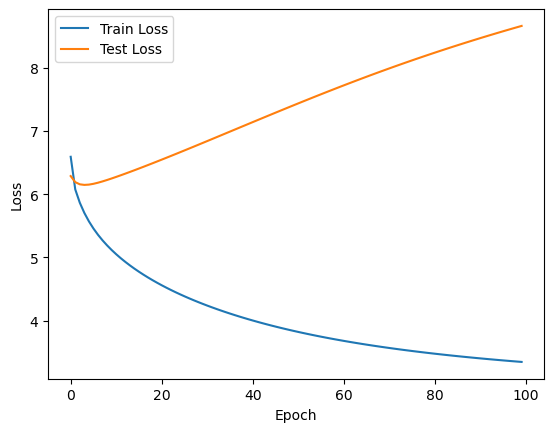

Context: ['the', 'psychologist', 's', 'a']
Predicted word: time
Target word: it
Context: ['own', 'times', 'how', 'wide']
Predicted word: time
Target word: and
Context: ['parting', 'were', 'frantic', 'and']
Predicted word: the
Target word: sometimes
Context: ['find', 'no', 'no', 'appliances']
Predicted word: have
Target word: machinery
Context: ['by', 'the', 'i', 'found']
Predicted word: first
Target word: door
Context: ['the', 'earth', 'fate', 'watching']
Predicted word: the
Target word: s
Context: ['the', 'natural', 'of', 'these']
Predicted word: speech
Target word: order
Context: ['run', 'short', 'they', 'had']
Predicted word: could
Target word: possibly
Context: ['slope', 'i', 'a', 'harsh']
Predicted word: and
Target word: heard
Context: ['perceived', 'that', 'had', 'the']
Predicted word: i
Target word: all


In [49]:
CONTEXT_SIZE = 2
EMBEDDING_DIM = 10
vocab_size = len(vocab)
cbow_dataset = create_cbow_dataset(words, CONTEXT_SIZE)
train_data, test_data = train_test_split(cbow_dataset)
# 创建CBOW数据集

model = CBOW(vocab_size, EMBEDDING_DIM)
# 初始化CBOW模型


def main():
    
    # 训练模型
    train_cbow(model, cbow_dataset, vocab)

    # 测试模型
    with torch.no_grad():
        for context, target in test_data[:10]:
            context_idxs = torch.tensor(vocab[context], dtype=torch.long)
            log_probs = model(context_idxs)
            predicted_word_idx = torch.argmax(log_probs).item()
            predicted_word = vocab.to_tokens(predicted_word_idx)
            print(f"Context: {context}")
            print(f"Predicted word: {predicted_word}")
            print(f"Target word: {target}")
    

if __name__ == "__main__":
    main()
    # 如果直接运行此脚本，执行main函数